In [20]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np

Types of analytics:
- View top k and bottom k emotion scores and their corresponding dialogues; can aggregate Alice and Bob or sort separately
- Histogram of dialogue scores with Alice and Bob overlaid.
- Summary stats: Average score for each emotion


In [29]:
def view_sorted_dialogues(emotion_metrics_path, emotions, extract_k, aggregate):
    emotion_metrics_df = pd.read_csv(emotion_metrics_path)

    all_dialogues = []
    all_scores = {emotion: [] for emotion in emotions}

    for index, row in emotion_metrics_df.iterrows():
        # Convert string literal to list of dialogues
        alice_dialogues = ast.literal_eval(row['alice_dialogues'])
        bob_dialogues = ast.literal_eval(row['bob_dialogues'])

        # Convert string literal to dictionary of <emotion, list of scores>
        alice_emotion_scores = ast.literal_eval(row['alice_emotion_scores'])
        bob_emotion_scores = ast.literal_eval(row['bob_emotion_scores'])

        for i, dialogue in enumerate(alice_dialogues):
            all_dialogues.append(dialogue)
            for emotion in emotions:
                all_scores[emotion].append(alice_emotion_scores[emotion][i])
        for i, dialogue in enumerate(bob_dialogues):
            all_dialogues.append(dialogue)
            for emotion in emotions:
                all_scores[emotion].append(bob_emotion_scores[emotion][i])

    for emotion in emotions:
        print(f"Emotion: {emotion}")
        # Sort the dialogues based on the current emotion                        
        paired = list(zip(all_scores[emotion], all_dialogues))
        sorted_pairs = sorted(paired, key=lambda x: x[0])

        # Get the top and bottom k
        top_k = sorted_pairs[-extract_k:]
        bottom_k = sorted_pairs[:extract_k]

        # Print the k highest and lowest scoring dialogues
        print(f"Top {extract_k} {emotion} scores:")
        for score, dialogue in reversed(top_k):
            print(f"{round(score, 1)}: {dialogue}")
        print(f"Bottom {extract_k} {emotion} scores:")
        for score, dialogue in bottom_k:
            print(f"{round(score, 1)}: {dialogue}")

In [24]:
def view_histogram(emotions_metric_path, emotions):

    emotion_metrics_df = pd.read_csv(emotions_metric_path)

    fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # Create a 3x2 grid for the plots
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

    for idx, emotion in enumerate(emotions):
        alice_scores = []
        bob_scores = []

        for index, row in emotion_metrics_df.iterrows():
            # Convert string literal to dictionary of <emotion, list of scores>
            alice_emotion_scores = ast.literal_eval(row['alice_emotion_scores'])
            bob_emotion_scores = ast.literal_eval(row['bob_emotion_scores'])

            alice_scores.extend(alice_emotion_scores[emotion])
            bob_scores.extend(bob_emotion_scores[emotion])

        bins = 20  # Adjusted bin size for better distribution capture
        axes[idx].hist(alice_scores, bins=bins, alpha=0.3, color='red', label='Alice')  # Increased transparency
        axes[idx].hist(bob_scores, bins=bins, alpha=0.3, color='blue', label='Bob')  # Increased transparency

        # Calculate mean and median
        alice_mean = np.mean(alice_scores)
        bob_mean = np.mean(bob_scores)
        alice_median = np.median(alice_scores)
        bob_median = np.median(bob_scores)

        # Add mean and median lines
        axes[idx].axvline(alice_mean, color='red', linestyle='dashed', linewidth=1, label='Alice Mean')
        axes[idx].axvline(bob_mean, color='blue', linestyle='dashed', linewidth=1, label='Bob Mean')
        axes[idx].axvline(alice_median, color='red', linestyle='solid', linewidth=1, label='Alice Median')
        axes[idx].axvline(bob_median, color='blue', linestyle='solid', linewidth=1, label='Bob Median')

        axes[idx].set_title(f'{emotion} Comparison')  # Updated title
        axes[idx].set_xlabel(f'{emotion} score')  # Updated X-axis label
        axes[idx].set_ylabel('Frequency')
        axes[idx].legend(loc='upper right')

    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()

In [22]:
emotion_metrics_path = "../data/emotion_metrics.csv"
emotions = ["happiness", "sadness", "anger", "fear", "disgust", "surprise"]

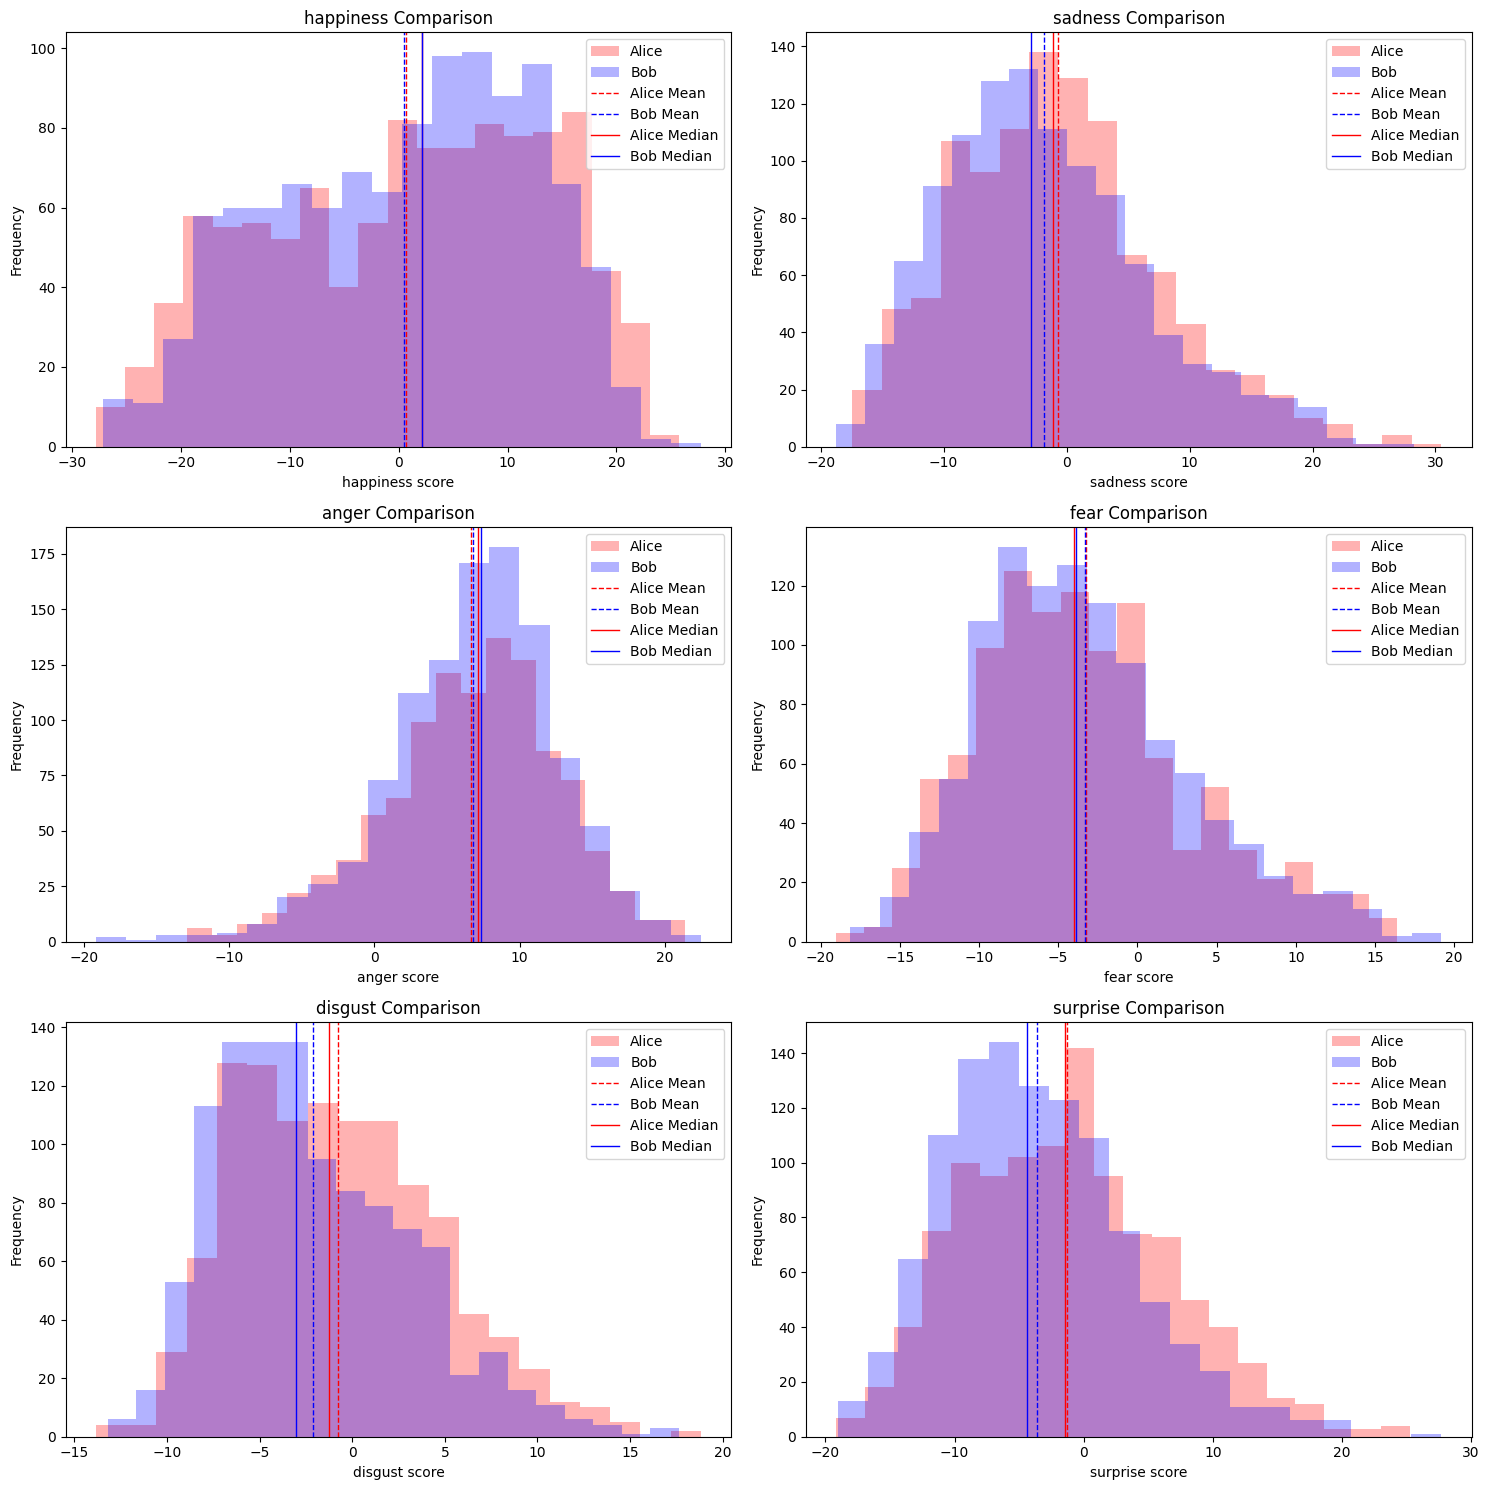

In [30]:
# view_sorted_dialogues(emotion_metrics_path, emotions, extract_k=2, aggregate=True)
view_histogram(emotion_metrics_path, emotions)